In [11]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
jet = mcm.get_cmap('jet')
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
%matplotlib inline 

filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Fe_Fep_Feb.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Na_Nap_Feb.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Mg_Mgp_Feb.nc"

filename2="Nc_Files/Jianfei_WACCMX_files/waccmx_T_Z3_e_Feb.nc"
#filename3="Nc_Files/Jianfei_WACCMX_files/waccmx_winds_Feb.nc"

M = filename[-10:]
Metal=M[0:2]
#print(Metal)

ds = xr.open_dataset(filename)
ds2 = xr.open_dataset(filename2)
#ds2
#ds

In [12]:
time = ds.variables['time']
times = xr.cftime_range(start="0001-02-01", periods=672, freq="1H", calendar="noleap")
times2 = ds["time"].dt.strftime("%Y%m%d %H:%M")

#timee = cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=None)

In [13]:
lon = ds.variables['lon']
lat = ds.variables['lat']
lev = ds.variables['lev']

dst = ds.transpose("lev", ...)
Mt = dst.variables[str(Metal)]
Mpt = dst.variables[str(Metal)+'p']

In [14]:
ds2t = ds2.transpose("lev", ...)
temp = ds2t.variables['T']
elect = ds2t.variables['e']

geopH = ds2t.variables['Z3'] / 1000 #m-> km
Zavg = geopH.mean(('time','lat', 'lon'))



In [15]:
# Slice arrays (lev, altitude) between chosen range

lev_sl_idx_min = 42
lev_sl_idx_max = 66
lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]

lev_sl_ind_min = lev[lev_sl_idx_min] 
lev_sl_ind_max = lev[lev_sl_idx_max] 
lev_sl_str = str("%.1e" % lev_sl_ind_min) + ' hPa : ' + str("%.1e" % lev_sl_ind_max) + ' hPa'
print('Plot lev = ' + lev_sl_str)


Zavg_sl = Zavg[lev_sl_idx_min:lev_sl_idx_max+1]

Zavg_sl_min = Zavg[lev_sl_idx_min] 
Zavg_sl_max = Zavg[lev_sl_idx_max]
Zavg_sl_str = str("%.0f" % Zavg_sl_min) + ' km : ' + str("%.0f" % Zavg_sl_max) + ' km'
print('Approx Z = ' + Zavg_sl_str)

geopH_sl = geopH[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]

Plot lev = 1.5e-05 hPa : 6.0e-03 hPa
Approx Z = 128 km : 81 km


In [16]:
# Slice e density and temp by chosen alt range and time range (first 2 weeks of data)

electr = elect[lev_sl_idx_min:lev_sl_idx_max+1,0:336,:,:]
tempe = temp[lev_sl_idx_min:lev_sl_idx_max+1,0:336,:,:]

#electr #lev: 25 time: 672 lat: 96 lon: 144
#tempe #lev: 25 time: 672 lat: 96 lon: 144

In [17]:
# VMR to number density calculation

edens = ( electr * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
#edens #lev: 25 time: 336 lat: 96 lon: 144

In [18]:
# Create array with time info for each day 
day = np.arange(0,24)

# Create an array with offset needed for each UT time step (24h period)
# Offset by 15 degrees lon, lon axis is in 2.5 degree intervals

os =  day * 15 / 2.5 

offset = np.empty(24, dtype=int) #Create offset array so it has same dims as day variable
for d in day:
    offset[d] =  ( int(os[d]) ) #convert floats to ints to get integer number of indices to offset by
print(offset)

# Stack multiple offset arrays to give offsets for consecutive days in the 2 week dataset 
offset2 = np.stack((offset, offset, offset, offset, offset, offset, offset), axis=0)
offset2 = np.reshape(offset2, (24*7))
offset3 = np.stack((offset2, offset2), axis=0)
offset3 = np.reshape(offset3, (168*2))
#offset3

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138]


In [19]:
#Create edens_sh array so it has same dims etc as edens variable
edens_sh = np.ndarray(edens.shape, dtype = float) 
#print(edens_sh.shape)   #(25, 336, 96, 144)


#Iterate over timear, offsetting e density at each time by 15 degrees lon
timear = np.arange(0,336)
for it in timear:
    edens_sh[:,it,:,:] = np.roll(edens[:,it,:,:], offset3[it] , axis=2)
    
#print(edens_sh.shape) #(25, 336, 96, 144)

In [20]:
#-----OFFSET-----#

# Calculate average of offset e densities along time axis
edens_avg = np.mean(edens_sh,  axis=1)
#print(edens_avg.shape) #(25, 96, 144)

# Calculate std dev of offset e densities along time axis
edens_std = np.std(edens_sh, axis=1)
#print(edens_std.shape) #(25, 96, 144)

In [21]:
#Calculate global average of e dens as fct of lev, find max over lev dimension (peak of layer)
#Use this as the lower limit for SpEs

#Mptdens_avg.shape #(25, 96, 144)
edens_avg1 = np.mean(edens_avg,  axis=1)
#Mptdens_avg1.shape #(25, 144)
edens_avg2 = np.mean(edens_avg1,  axis=1)
edens_avg2.shape #25
max_edens_avg2 = np.amax(edens_avg2, axis=0)
#max_Mptdens_avg2 = 1205.8034370224923


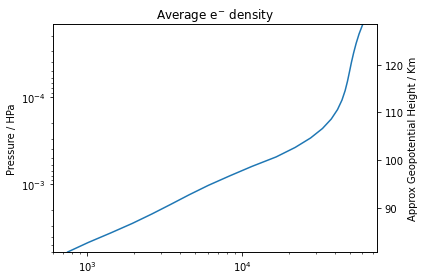

In [24]:
fig = plt.figure()
ax = plt.axes()

ax.plot(edens_avg2, lev_sl)

ax.set_title('Average e$^{-}$ density')

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl[-1], lev_sl[0]) 

ax.set_xscale('log')

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl[-1],Zavg_sl[0])

figname= 'Average e- density as fct of height' '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' +str(figname), dpi = 300)

In [11]:
levar = np.arange(0,25)
latar = np.arange(0,96)
lonar = np.arange(0,144)

In [15]:
#-----OFFSET-----#

# Calculate difference between e density from model output and the average e density 

# Where the difference is less than set value of sigma, set to NaN
sigma_val = 1.5   #1sigma~68%   1.5sigma~87%    2sigma~95%
sigma_val_str = str(sigma_val)

edens_diff = np.ndarray(edens.shape, dtype = float) 
SpEs = np.ndarray(edens.shape, dtype = float) 
SpEs_sh = np.ndarray(edens.shape, dtype = float) 
SpEs_sh_lim = np.ndarray(edens.shape, dtype = float) 

for it in timear:
    edens_diff[:,it,:,:] = edens_sh[:,it,:,:] - edens_avg     

SpEs_sh_nan = np.empty(edens.shape)
SpEs_sh_nan[:] = np.NaN


for it in timear:
    SpEs_sh[:,it,:,:] = np.where( edens_diff[:,it,:,:]>(sigma_val*edens_std) , edens_sh[:,it,:,:] , SpEs_sh_nan[:,it,:,:] )        
    SpEs_sh_lim[:,it,:,:] = np.where( (edens_diff[:,it,:,:]>(sigma_val*edens_std)) & (edens_sh[:,it,:,:]>SpEs_lim), edens_sh[:,it,:,:] , SpEs_sh_nan[:,it,:,:] )


#Set string values for sigma symbol to use in plot
sigma_symb_str = 'sigma: \u03C3'
sigma = sigma_symb_str[-1]


NameError: name 'SpEs_lim' is not defined

In [ ]:
#----------------Set up Local Time Ticks-------------------------

timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 
timeconv_plot_hrly = timeconv_plot[::6]
#print(timeconv_plot.shape) #144
#print(timeconv_plot_hrly.shape) #24

timeconv_plot_ticks = np.empty((25))
tickar = np.arange(0,24)

for itick in tickar:
    timeconv_plot_ticks[itick] = timeconv_plot_hrly[itick]

timeconv_plot_ticks[-1] = timeconv_plot_ticks[-2] + 1.
#print(timeconv_plot_ticks)

In [14]:
#------------------------ Plot 1 setup: SpEs_plot-----------------------------

lev_sl_plot1_idx = 15   #15 #~94km      #23=82km low lim?
lev_sl_plot1 = lev_sl[lev_sl_plot1_idx]
lev_sl_plot1_str = str("%.1e" % lev_sl_plot1) + ' hPa'
print('Plot lev = ' + lev_sl_plot1_str)


Zavg_slplot1 = Zavg_sl[lev_sl_plot1_idx]
Zavg_sl_plot1_str = str("%.0f" % Zavg_slplot1) + ' km'
print('Approx Z = ' + Zavg_sl_plot1_str)

#time_plot1_idx = 12 #3
#time_plot1 = time[time_plot1_idx]

#times_plot1 = times[time_plot1_idx]
#times_plot1_str = str(times_plot1)
#print('Plot time = ' + times_plot1_str)


Plot lev = 6.3e-04 hPa
Approx Z = 94 km


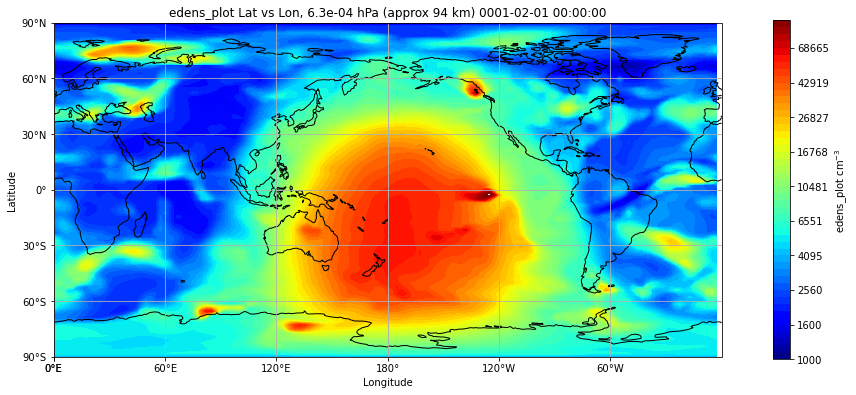

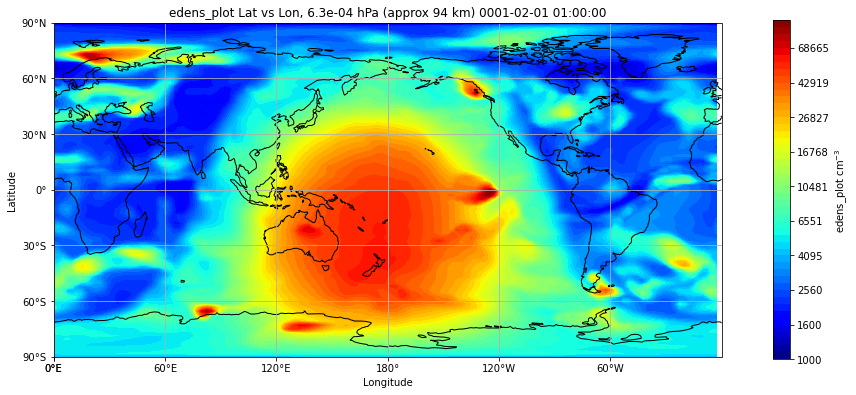

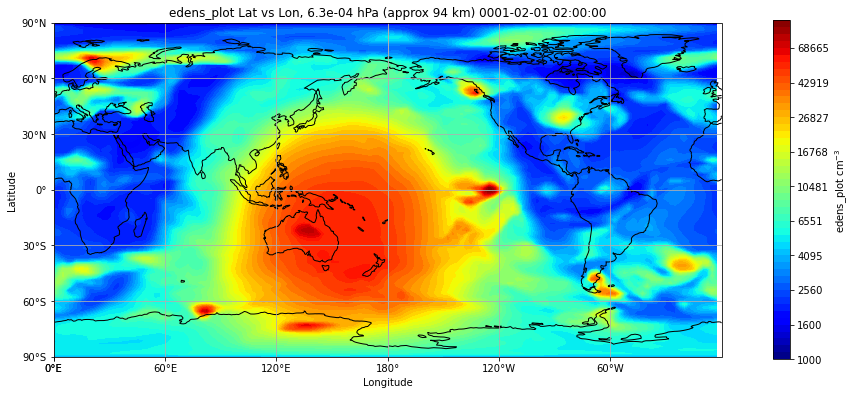

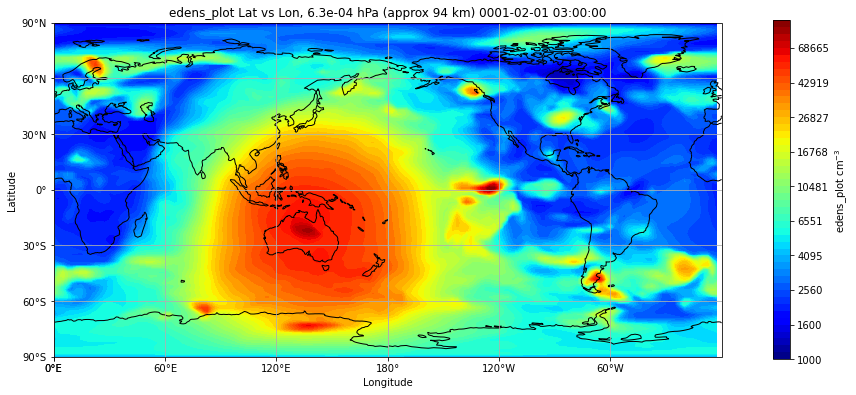

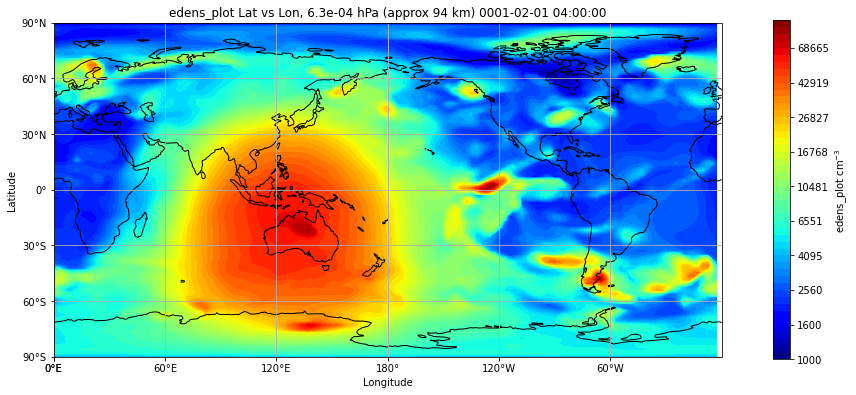

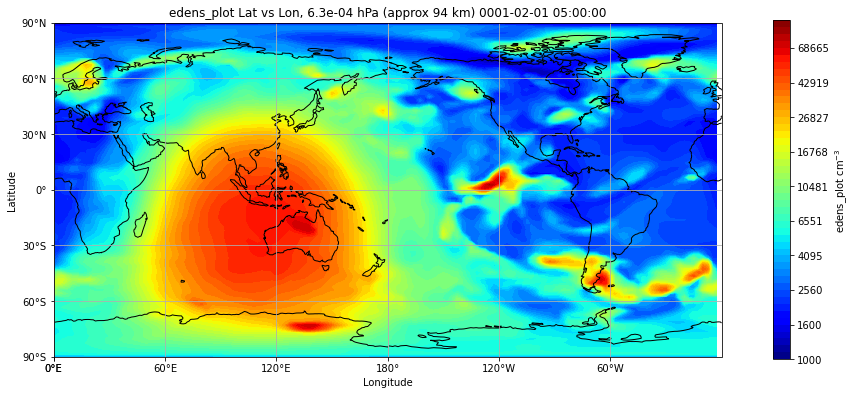

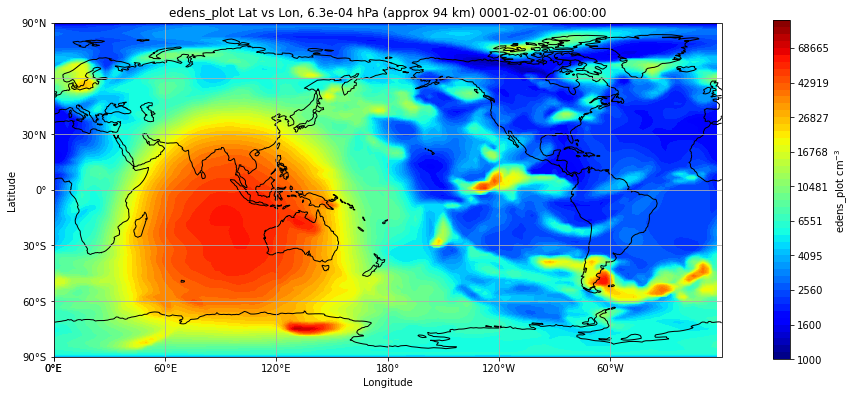

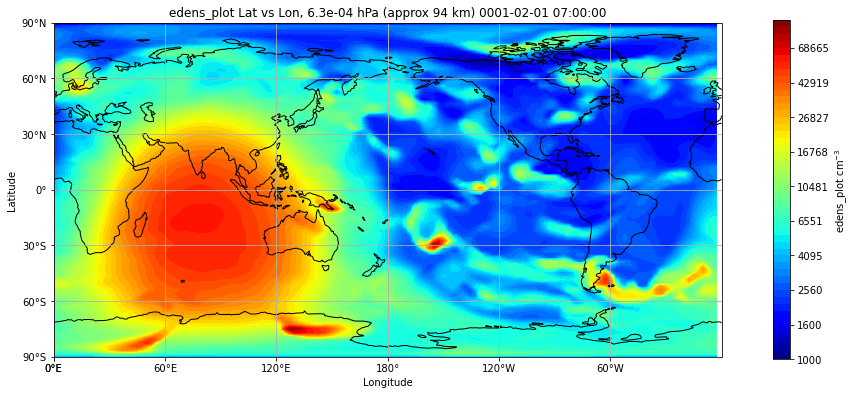

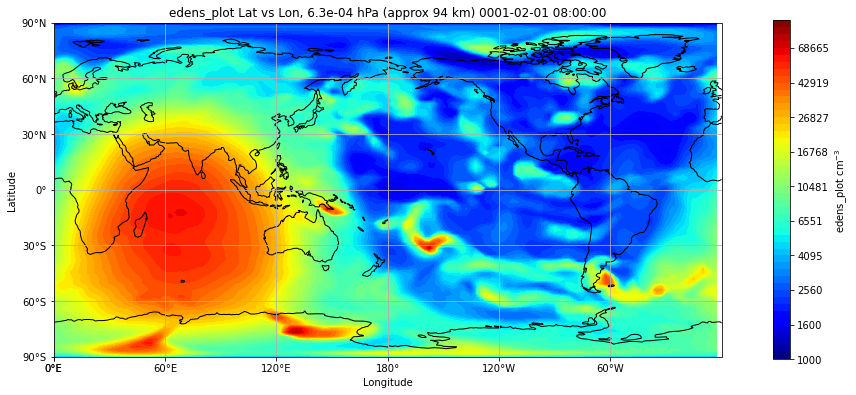

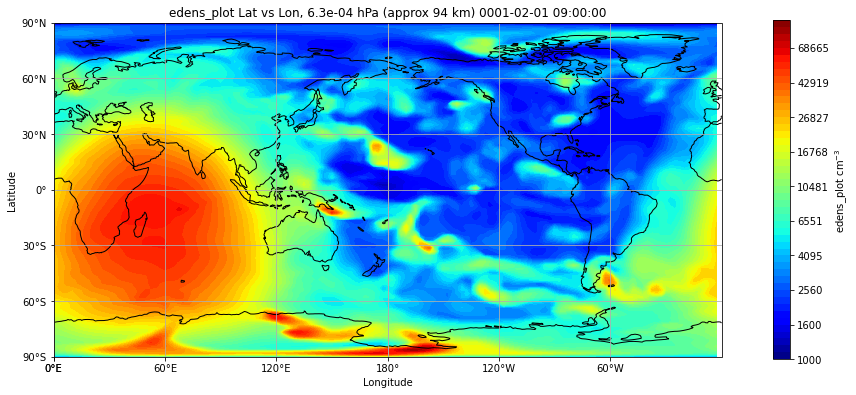

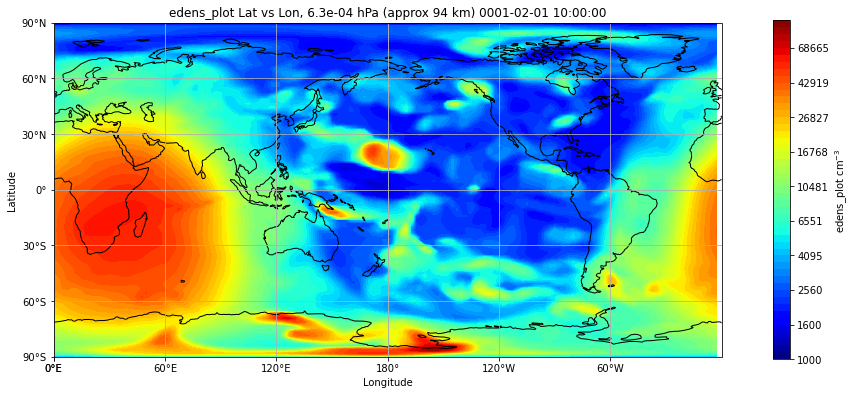

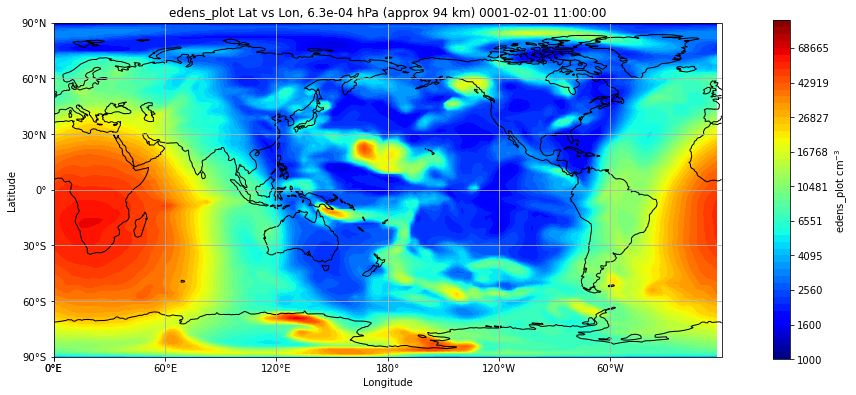

In [15]:
#----------------------------------------------------------------------------------------------------------
#----------------------------------edens_plot (Lat vs Lon)-------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot1_idx_start = 0  
time_plot1_idx_end = 12

time_plot1_ar = np.arange(time_plot1_idx_start,time_plot1_idx_end)

for itime in time_plot1_ar:
    time_plot1_idx = time_plot1_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------

    time_plot1 = time[time_plot1_idx]

    times_plot1 = times[time_plot1_idx]
    times_plot1_str = str(times_plot1)
    #print('Plot time = ' + times_plot1_str)

    #---------------Set up plot variables----------------------------
    edens_plot = edens[lev_sl_plot1_idx,time_plot1_idx,:,:]

    #------------------------ Plot 1.0:  -----------------------------

    ticks = np.geomspace(1*10**3, 1*10**5)

    fig = plt.figure(figsize=(12,8))

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_global()

    C = plt.contourf(lon, lat, edens_plot, 
                     levels=ticks,
                     transform=ccrs.PlateCarree(),
                     locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.coastlines() 
    ax.gridlines()

    ax.set_xlabel('Longitude')

    #ax.set_xticks([0, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], crs=ccrs.PlateCarree())
    ax.set_xticks([0, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    ax.set_ylabel('Latitude')
    ax.set_title('edens_plot Lat vs Lon, ' + 
                 lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + ') ' + times_plot1_str )

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, fraction=0.023, pad=0.07)#,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#) #
    #-------------------

    cbar.set_label(r'edens_plot cm$^{-3}$')

    figname='edens_plot: Lat vs Lon ' + lev_sl_plot1_str + ' '+ times_plot1_str + '.png'
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+str(figname), dpi = 300) #
    plt.tight_layout()
    #plt.show()

    #--------------------------------------------------------


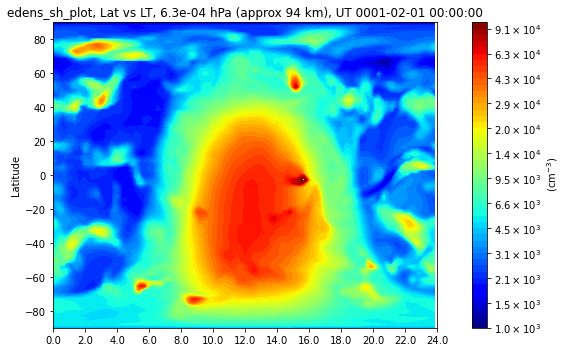

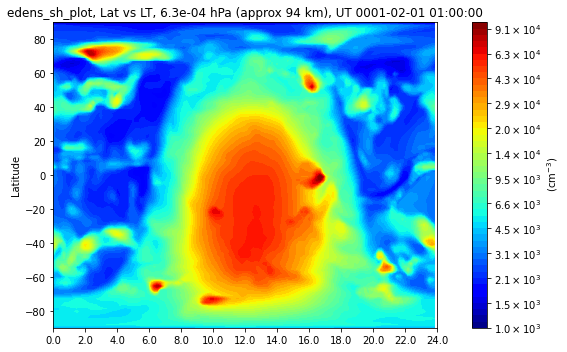

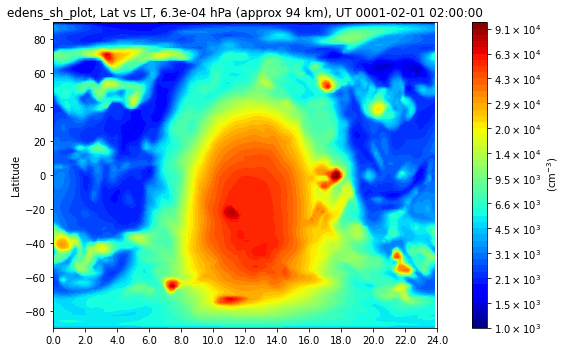

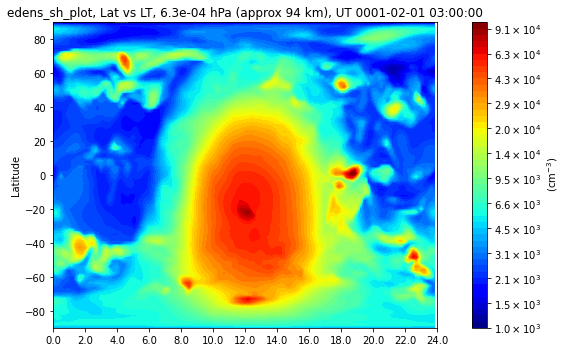

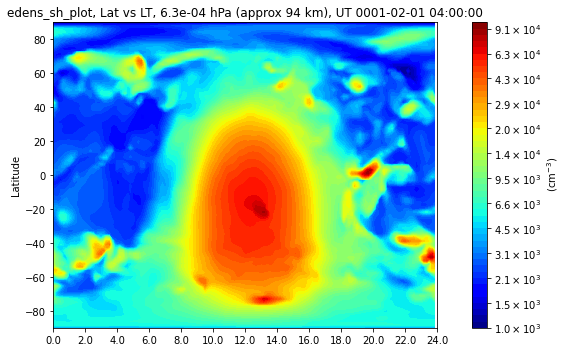

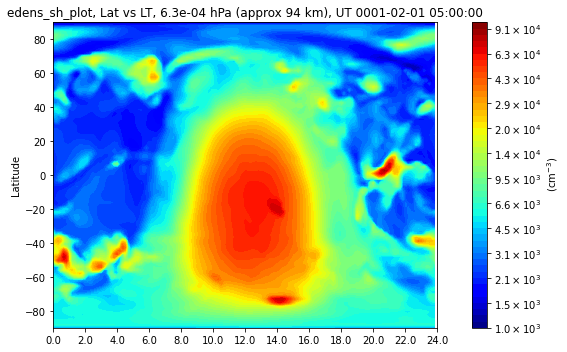

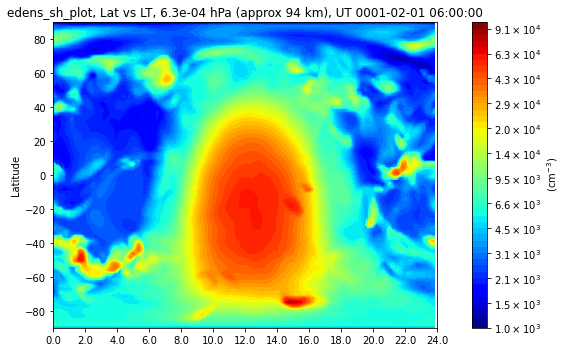

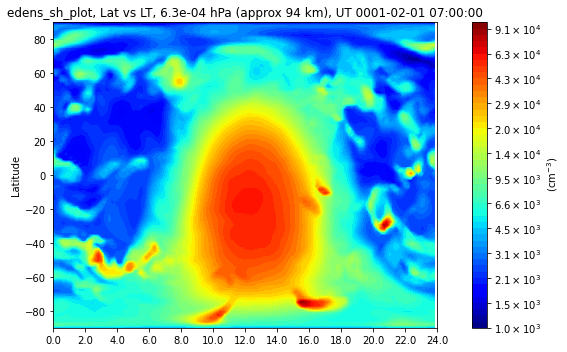

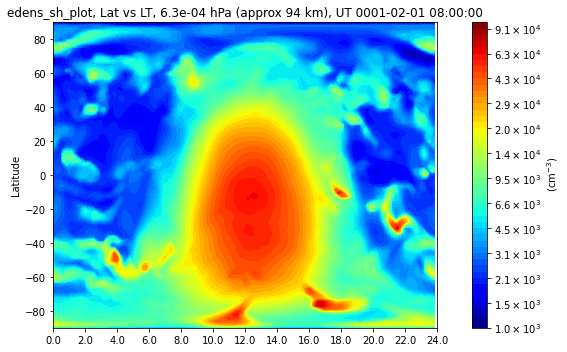

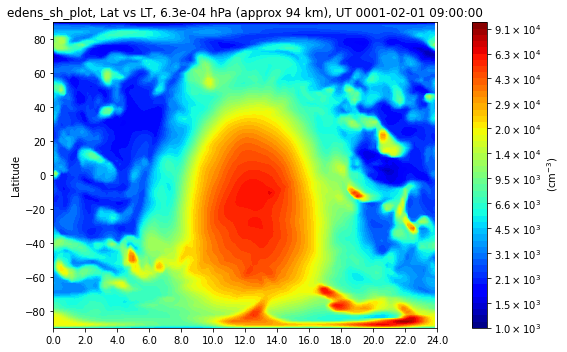

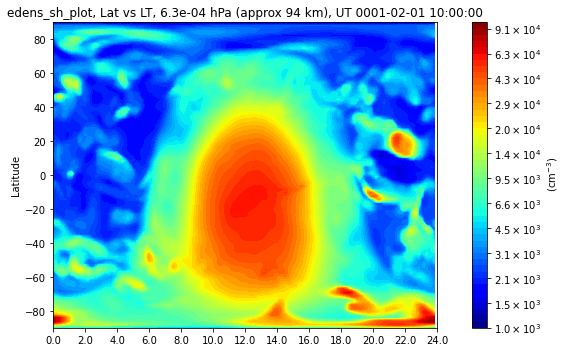

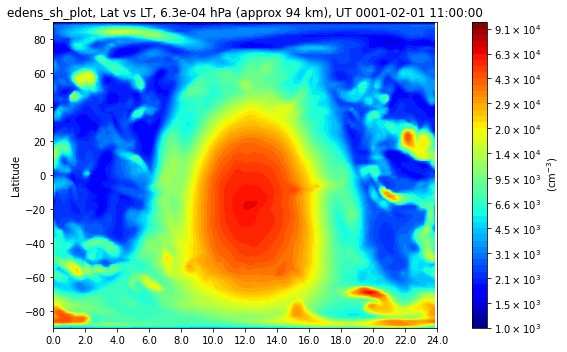

In [25]:
#----------------------------------------------------------------------------------------------------------
#-------------------------------------------edens_sh_plot---------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot1_idx_start = 0  
time_plot1_idx_end = 12

time_plot1_ar = np.arange(time_plot1_idx_start,time_plot1_idx_end)

for itime in time_plot1_ar:
    time_plot1_idx = time_plot1_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------

    time_plot1 = time[time_plot1_idx]

    times_plot1 = times[time_plot1_idx]
    times_plot1_str = str(times_plot1)
    #print('Plot time = ' + times_plot1_str)

    #---------------Set up plot variables----------------------------
    
    edens_sh_plot = edens_sh[lev_sl_plot1_idx,time_plot1_idx,:,:]

    #------------------------ Plot 1.0:  -----------------------------

    ticks = np.geomspace(1*10**3, 1*10**5)

    fig, ax = plt.subplots(figsize=(8, 5))
    C = ax.contourf(timeconv_plot, lat, edens_sh_plot, 
                     levels=ticks,
                     locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_xticks(np.linspace(0,24,13)) 
    #ax.set_xticklabels(LT_plot_ticks[::2]) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('edens_sh_plot, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '), UT ' + times_plot1_str )

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' (cm$^{-3}$)')

    figname='edens_sh_plot: Lat vs LT ' + lev_sl_plot1_str + times_plot1_str + '.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+str(figname), dpi = 300) #

In [ ]:
#----------------------------------------------------------------------------------------------------------
#-------------------------------------------edens_std_plot---------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot1_idx_start = 0  
time_plot1_idx_end = 12

time_plot1_ar = np.arange(time_plot1_idx_start,time_plot1_idx_end)

for itime in time_plot1_ar:
    time_plot1_idx = time_plot1_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------

    time_plot1 = time[time_plot1_idx]

    times_plot1 = times[time_plot1_idx]
    times_plot1_str = str(times_plot1)
    #print('Plot time = ' + times_plot1_str)

    #---------------Set up plot variables----------------------------

    edens_std_plot = edens_std[lev_sl_plot1_idx,:,:]

    #------------------------ Plot 1.0:  -----------------------------

    ticks = np.geomspace(1*10**3, 1*10**5)
    #ticks = np.linspace(0, 120, 33)

    fig, ax = plt.subplots(figsize=(8, 5))
    C = ax.contourf(timeconv_plot, lat, edens_std_plot, 
                     levels=ticks,
                     locator=ticker.LogLocator(),
                     extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_xticks(np.linspace(0,24,13)) 
    #ax.set_xticklabels(LT_plot_ticks[::2]) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('edens_std_plot, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '), UT ' + times_plot1_str )

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' (cm$^{-3}$)')

    figname='edens_std_plot: Lat vs LT ' + lev_sl_plot1_str + times_plot1_str + '.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+str(figname), dpi = 300) #

In [ ]:
#----------------------------------------------------------------------------------------------------------
#-------------------------------------------edens_avg_plot---------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot1_idx_start = 0  
time_plot1_idx_end = 12

time_plot1_ar = np.arange(time_plot1_idx_start,time_plot1_idx_end)

for itime in time_plot1_ar:
    time_plot1_idx = time_plot1_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------

    time_plot1 = time[time_plot1_idx]

    times_plot1 = times[time_plot1_idx]
    times_plot1_str = str(times_plot1)
    #print('Plot time = ' + times_plot1_str)

    #---------------Set up plot variables----------------------------

    edens_avg_plot = edens_avg[lev_sl_plot1_idx,:,:]
   
    #------------------------ Plot 1.0:  -----------------------------

    ticks = np.geomspace(1*10**3, 1*10**5)
    #ticks = np.linspace(0, 120, 33)

    fig, ax = plt.subplots(figsize=(8, 5))
    C = ax.contourf(timeconv_plot, lat, edens_avg_plot, 
                     levels=ticks,
                     locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_xticks(np.linspace(0,24,13)) 
    #ax.set_xticklabels(LT_plot_ticks[::2]) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('edens_avg_plot, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '), UT ' + times_plot1_str )

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' (cm$^{-3}$)')

    figname='edens_avg_plot: Lat vs LT ' + lev_sl_plot1_str + times_plot1_str + '.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+str(figname), dpi = 300) #

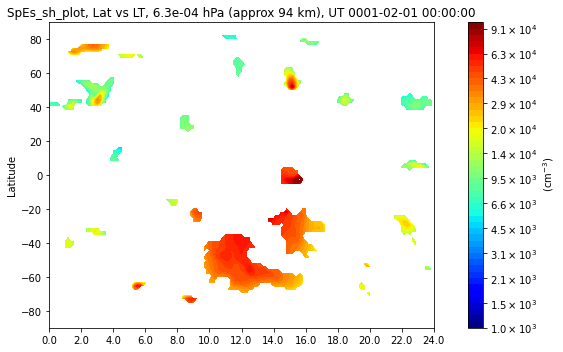

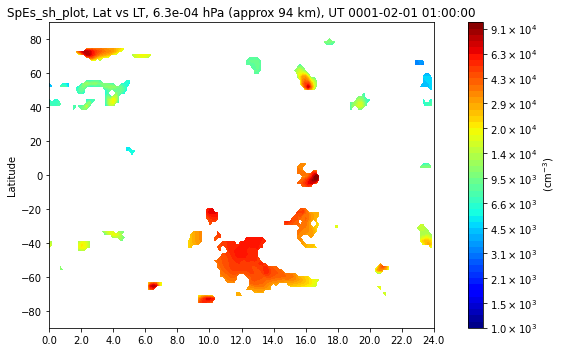

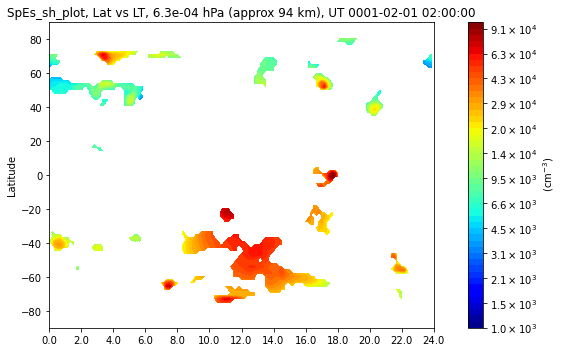

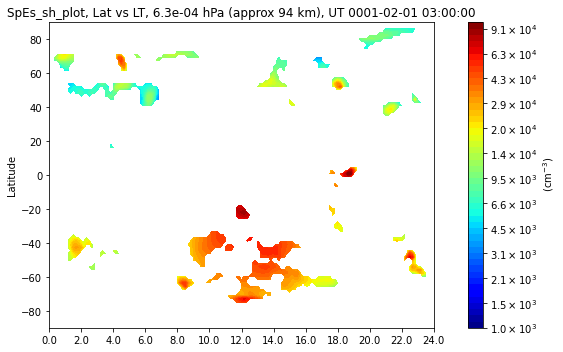

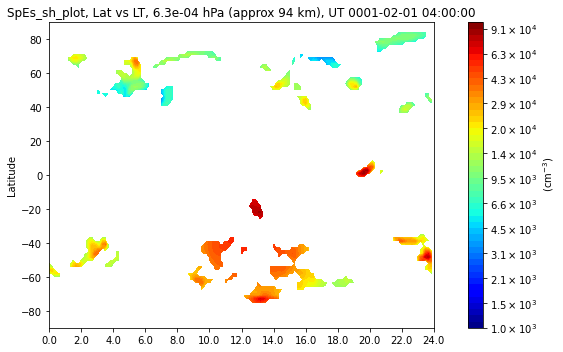

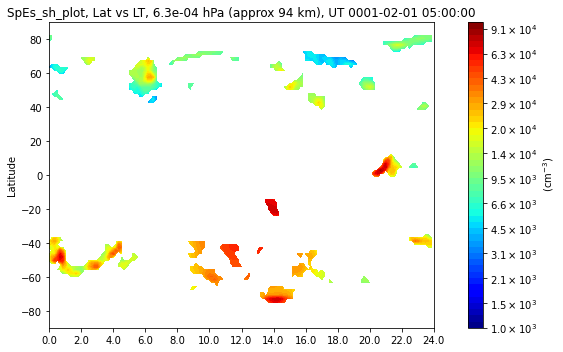

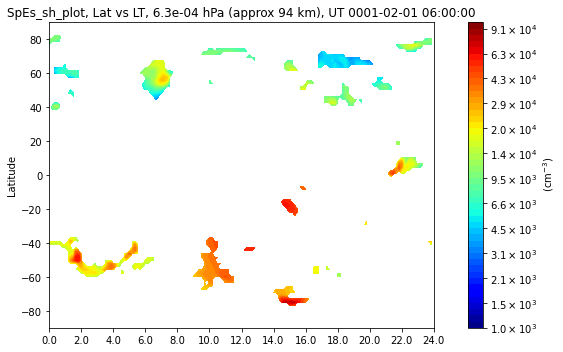

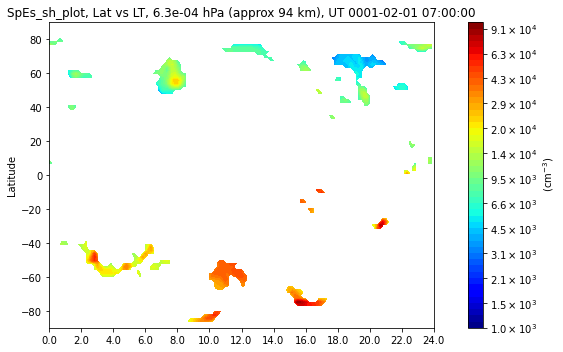

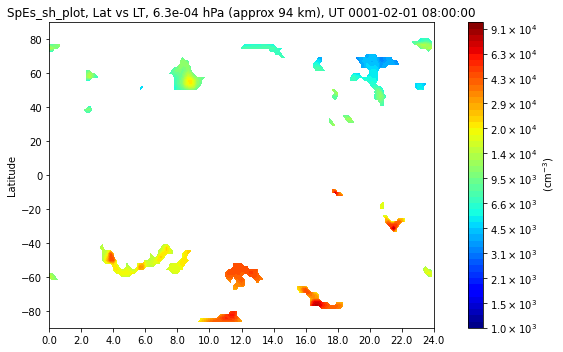

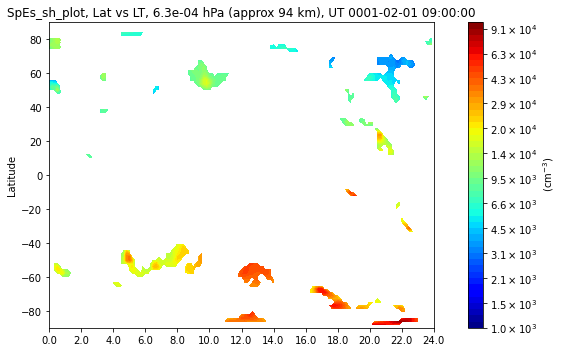

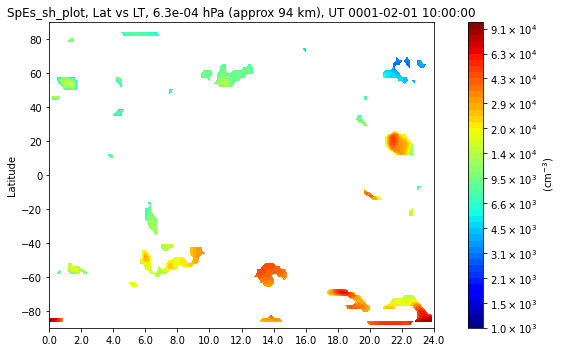

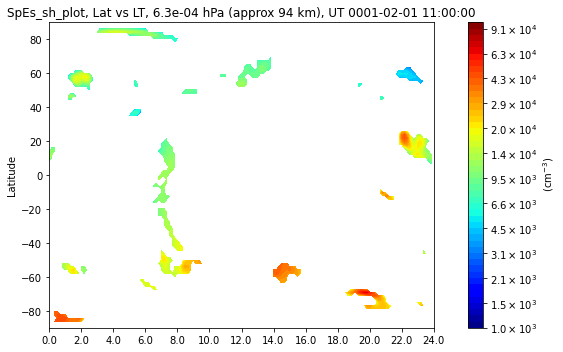

In [74]:
#----------------------------------------------------------------------------------------------------------
#-------------------------------------------SpEs_sh_plot---------------------------------------------------
#----------------------------------------------------------------------------------------------------------


time_plot1_idx_start = 0  
time_plot1_idx_end = 12

time_plot1_ar = np.arange(time_plot1_idx_start,time_plot1_idx_end)

for itime in time_plot1_ar:
    time_plot1_idx = time_plot1_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------

    time_plot1 = time[time_plot1_idx]

    times_plot1 = times[time_plot1_idx]
    times_plot1_str = str(times_plot1)
    #print('Plot time = ' + times_plot1_str)

    #---------------Set up plot variables----------------------------

    SpEs_sh_plot = SpEs_sh[lev_sl_plot1_idx,time_plot1_idx,:,:]
 
    #------------------------ Plot 1.0:  -----------------------------

    ticks = np.geomspace(1*10**3, 1*10**5)
    #ticks = np.linspace(0, 120, 33)

    fig, ax = plt.subplots(figsize=(8, 5))
    C = ax.contourf(timeconv_plot, lat, SpEs_sh_plot, 
                     levels=ticks,
                     locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_xticks(np.linspace(0,24,13)) 
    #ax.set_xticklabels(LT_plot_ticks[::2]) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('SpEs_sh_plot, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '), UT ' + times_plot1_str )

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' (cm$^{-3}$)')

    figname='SpEs_sh_plot: Lat vs LT ' + lev_sl_plot1_str + times_plot1_str + '.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+str(figname), dpi = 400) #

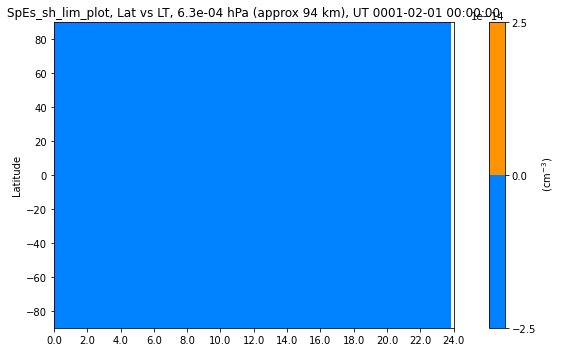

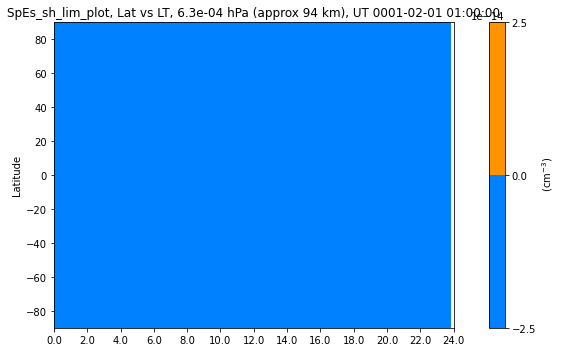

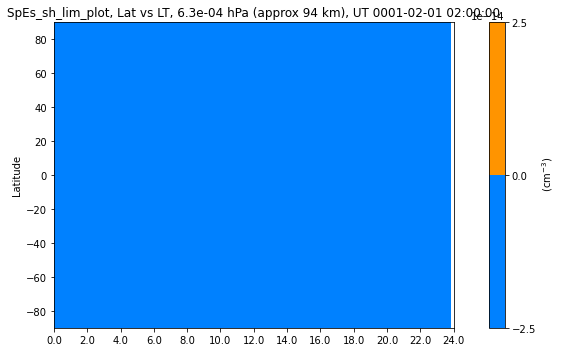

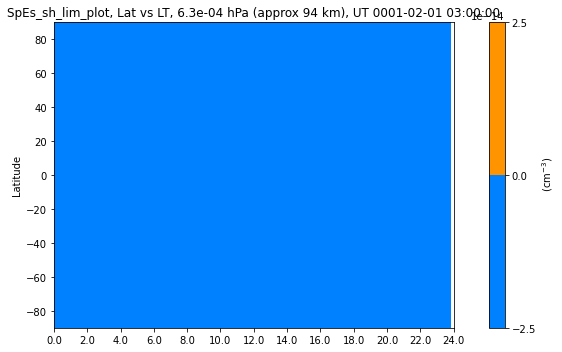

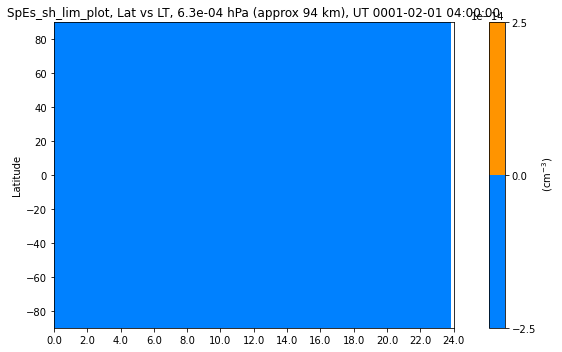

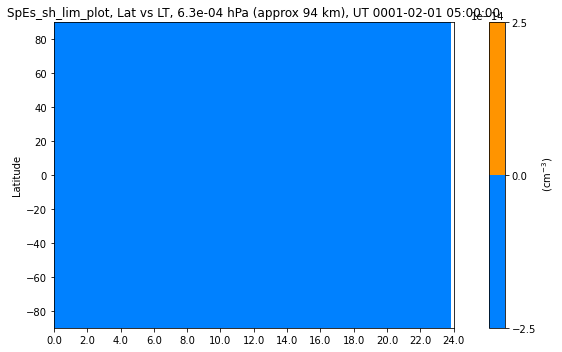

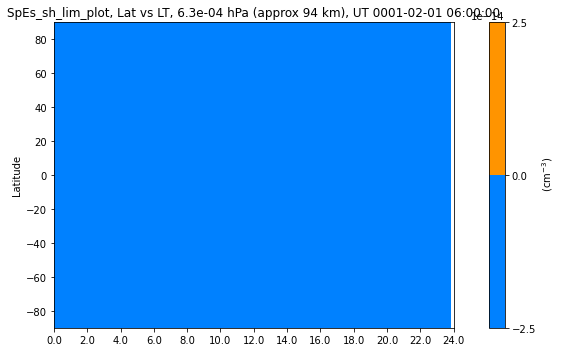

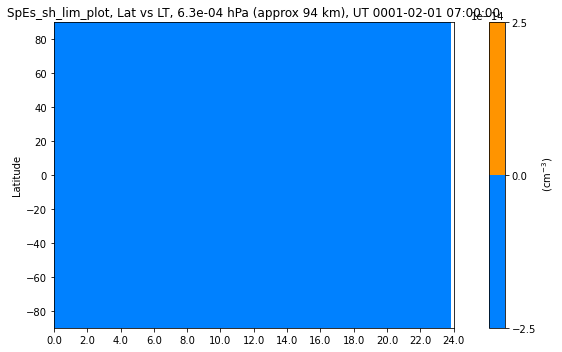

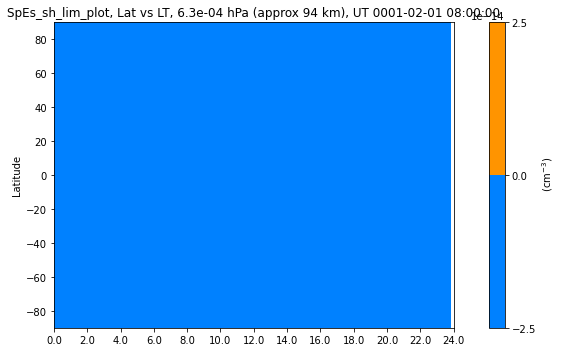

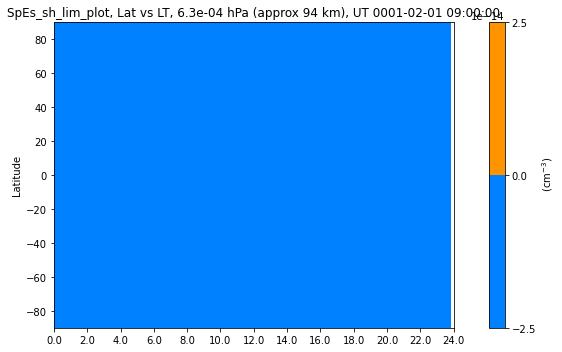

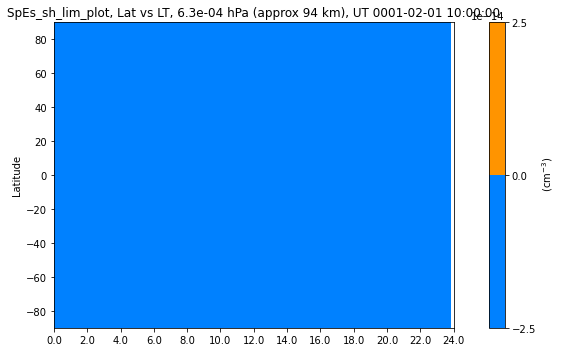

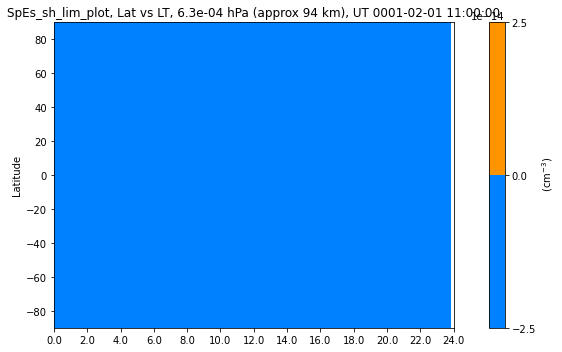

In [19]:
#----------------------------------------------------------------------------------------------------------
#-------------------------------------------SpEs_sh_plot---------------------------------------------------
#----------------------------------------------------------------------------------------------------------


time_plot1_idx_start = 0  
time_plot1_idx_end = 12

time_plot1_ar = np.arange(time_plot1_idx_start,time_plot1_idx_end)

for itime in time_plot1_ar:
    time_plot1_idx = time_plot1_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------

    time_plot1 = time[time_plot1_idx]

    times_plot1 = times[time_plot1_idx]
    times_plot1_str = str(times_plot1)
    #print('Plot time = ' + times_plot1_str)

    #---------------Set up plot variables----------------------------

    SpEs_sh_lim_plot = SpEs_sh_lim[lev_sl_plot1_idx,time_plot1_idx,:,:]

    #------------------------ Plot 1.0:  -----------------------------

    #ticks = np.geomspace(1*10**3, 1*10**5)

    fig, ax = plt.subplots(figsize=(8, 5))
    C = ax.contourf(timeconv_plot, lat, SpEs_sh_lim_plot, 
                     #levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_xticks(np.linspace(0,24,13)) 
    #ax.set_xticklabels(LT_plot_ticks[::2]) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('SpEs_sh_lim_plot, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '), UT ' + times_plot1_str )

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' (cm$^{-3}$)')

    figname='SpEs_sh_lim_plot: Lat vs LT ' + lev_sl_plot1_str + times_plot1_str + '.png'
    plt.tight_layout()
    #plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+str(figname), dpi = 400) #

In [73]:
#-------------Define SpEs as based on relative diff from avg rather than absolute-----------------

percentage_diff = np.ndarray(edens.shape, dtype = float) 
SpEs_pd = np.ndarray(edens.shape, dtype = float) 

for it in timear:
    percentage_diff[:,it,:,:] = ( edens_diff[:,it,:,:] / edens_avg ) * 100.    #Diff(25, 336, 96, 144) #Avg(25, 96, 144)

#percentage_lim = 87. #~1.5 sigma
percentage_lim = 68. #~1 sigma
#percentage_lim = 38. #~0.5 sigma
percentage_lim_str = str(percentage_lim)

SpEs_pd_nan = np.empty(edens.shape)
SpEs_pd_nan[:] = np.NaN
#SpEs_pd.shape

SpEs_pd = np.where(percentage_diff  > percentage_lim, edens_sh, SpEs_pd_nan)

In [ ]:
#----------------------------------------------------------------------------------------------------------
#-------------------------------------------SpEs_pd_plot---------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot1_idx_start = 0  
time_plot1_idx_end = 12

time_plot1_ar = np.arange(time_plot1_idx_start,time_plot1_idx_end)

for itime in time_plot1_ar:
    time_plot1_idx = time_plot1_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------

    time_plot1 = time[time_plot1_idx]

    times_plot1 = times[time_plot1_idx]
    times_plot1_str = str(times_plot1)
    #print('Plot time = ' + times_plot1_str)

    #---------------Set up plot variables----------------------------

    percentage_diff_plot = percentage_diff[lev_sl_plot1_idx,time_plot1_idx,:,:]

    SpEs_pd_plot = SpEs_pd[lev_sl_plot1_idx,time_plot1_idx,:,:]

    #------------------------ SpEs_pd_plot -----------------------------

    ticks = np.geomspace(1*10**3, 1*10**5)

    fig, ax = plt.subplots(figsize=(8, 5))
    C = ax.contourf(timeconv_plot, lat, SpEs_pd_plot, 
                     levels=ticks,
                     locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    ax.set_ylabel('Latitude')
    ax.set_xticks(np.linspace(0,24,13)) 
    #ax.set_xticklabels(LT_plot_ticks[::2]) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('SpEs_pd_plot, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '), UT ' + times_plot1_str )

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' (cm$^{-3}$)')

    figname='SpEs_pd_plot: Lat vs LT ' + lev_sl_plot1_str + times_plot1_str + '.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+str(figname), dpi = 300) #
    
   